In [1]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numba import jit
import potentials
from distances import *
from scipy.special import erfc
import line_profiler

In [2]:
class Ewald(object):
    
    def __init__(self, charges, boxsize,alpha, r_cutoff, n_max, k_cutoff):
        #probably includes redundant parameters, will remove some in the future
        self.boxsize = boxsize
        self.L = boxsize[1] - boxsize[0]
        self.vol = self.L**3
        self.a = alpha
        self.nm = n_max
        self.rc = r_cutoff
        self.kc = k_cutoff
        self.n_max = n_max
        self.q = charges
        self.k_array = np.asarray([[i,j, k] 
                                   for i in range(int(self.kc)+1) 
                                   for j in range(int((self.kc**2-i**2)**(1/2))+1)
                                   for k in range(int((self.kc**2-i**2-j**2)**(1/2)+1)) if (i,j,k)!=(0,0,0)])
        self.k_array = np.concatenate([[i,j,1]*self.k_array for i in [-1, 1] for j in [-1, 1]])
        self.n_array = np.mgrid[-n_max:n_max+1,-n_max:n_max+1,-n_max:n_max+1].reshape(3,-1).T
   
    @property
    def params(self):
        return self.a, self.rc, self.nm, self.kc
    
    @params.setter
    def params(self, params):
        self.a = params[0]
        self.rc = params[1]
        if self.nm != params[2]:
            self.nm = params[2]
            self.n_array = np.mgrid[-self.nm:self.nm+1,-self.nm:self.nm+1,-self.nm:self.nm+1].reshape(3,-1).T
        if self.kc != params[3]:
            self.kc = params[3]
            self.k_array = np.asarray([[i,j, k] 
                                   for i in range(int(self.kc)+1) 
                                   for j in range(int((self.kc**2-i**2)**(1/2))+1)
                                   for k in range(int((self.kc**2-i**2-j**2)**(1/2)+1)) if (i,j,k)!=(0,0,0)])
            self.k_array = np.concatenate([[i,j,1]*self.k_array for i in [-1, 1] for j in [-1, 1]]) 
              
    def pot_sr(self, coord):
        i_dvec = self.n_array[:,None,None]-vectors(coord, self.boxsize)
        dist = distances(i_dvec) #calculates the pairwise particle distances, including images
        mask = dist>=self.rc #particle-particle interactions are ignored if interparticle distance exceeds cutoff radius
        dist = np.ma.masked_array(dist, dist==0) #division by zero is prevented
        dist_ma = np.ma.masked_array(dist, mask) #applies cutoff mask to distance matrix
        return np.sum(1/2*self.q[:,None]*self.q[None,:]*1/dist_ma*erfc(self.a*dist_ma))
    
    def S(self,coord):
        #calculates the absolute squared of S(k) (structure factor inside imaginary part of Ewald sum)
        k_r = np.tensordot(self.k_array,coord, axes=(-1, -1)) #calculates the scalar product of all k-vectors with the position vectors k_r[i,j] = dot(k[i],r[j]) 
        s_re = np.tensordot(self.q, np.cos(2*np.pi*k_r), axes=(-1, -1))
        s_im = np.tensordot(self.q, np.sin(2*np.pi*k_r), axes=(-1, -1))
        return s_re**2 + s_im**2
       
    def pot_lr(self, coord):
        #long-ranged potential that is calculated in reciprocal space. Cutoff is defined by k_cutoff (see init)
        k_abs = np.linalg.norm(self.k_array,axis=-1)
        return 1/(np.pi*self.vol)*np.sum((np.exp(-(np.pi*k_abs/self.a)**2)/k_abs**2)*self.S(coord))
    
    def pot_self(self):
        #self-interaction potential, that has to be corrected for in the Ewald sum
        return self.a/np.sqrt(np.pi)*np.linalg.norm(self.q)**2
    
    def pot(self, coord):
        return np.ma.sum((self.pot_sr(coord),self.pot_lr(coord), - self.pot_self()))
    
    def force_sr(self, coord):
        i_dvec = self.n_array[:,None,None]-vectors(coord, self.boxsize)
        dist = distances(i_dvec)
        mask = dist>=self.rc #particle-particle interactions are ignored if interparticle distance exceeds cutoff radius
        dist = np.ma.masked_array(dist, mask)
        dist = np.ma.masked_array(dist, dist==0) #division by zero is prevented
        s1, s2 = erfc(self.a*dist), 2*self.a/np.sqrt(np.pi)*dist*np.exp(-(self.a*dist)**2)
        return self.q[:, None] * np.ma.sum((self.q[None,:]/(dist**3)*(s1 + s2))[:,:,:,None] * i_dvec, axis=(0, 2))
    
    def force_lr(self, coord):
        dvec = -vectors(coord, self.boxsize)
        k_abs = np.linalg.norm(self.k_array,axis=-1)
        k_r = np.tensordot(self.k_array,dvec, axes=(-1, -1))
        f1, f2 = np.pi/(E.a*E.L), 2*np.pi/E.L
        f3=(1/k_abs**2*np.exp(-(f1*k_abs)**2))
        f4=f3[:,None,None]*np.sin(f2*k_r)
        f5=(E.k_array[:,:,None,None]*f4[:,None,:])
        return 4*E.q[:, None]/E.L * np.sum(f5, axis=(0, -1)).T
    
    def force(self, coord):
        return self.force_lr(coord) + self.force_sr(coord)
        

In [3]:
def nacl_ewald(r_cutoff, n_max, k_cutoff, max_a, step_a, E=None):
    coord =np.asarray([[0,0,0], [1/2,1/2,0], [1/2,0,1/2], [0,1/2,1/2],
                           [1/2,1/2,1/2], [1/2,0,0], [0,1/2,0],[0,0,1/2]])
    if E==None:
        charges = np.asarray([-1, -1., -1, -1, 1, 1, 1, 1])
        E = Ewald(charges, (0,1), 0.1, r_cutoff, n_max, k_cutoff)
    a_array = np.arange(0.1, max_a, step_a)
    pot_lr, pot_sr, pot_self = np.zeros_like(a_array), np.zeros_like(a_array), np.zeros_like(a_array)
    for i in range(len(a_array)):
        E.params = (a_array[i], r_cutoff, n_max, k_cutoff)
        pot_lr[i] = E.pot_lr(coord)
        pot_sr[i] = E.pot_sr(coord)
        pot_self[i] = E.pot_self()
    pot_total = pot_lr + pot_sr - pot_self
    return np.asarray([a_array, pot_lr, pot_sr, pot_self, pot_total])

In [4]:
a_array, pot_lr, pot_sr, pot_self, pot_total=nacl_ewald(10, 5, 10, 5,0.1)
print("Madelung's constant from Ewald:",np.sum(pot_total[12:]/len(pot_total[12:])/8))
print("Madelung's constant from liter:",-1.7475645946331821)

Madelung's constant from Ewald: -1.7475645946331824
Madelung's constant from liter: -1.7475645946331821


<IPython.core.display.Javascript object>


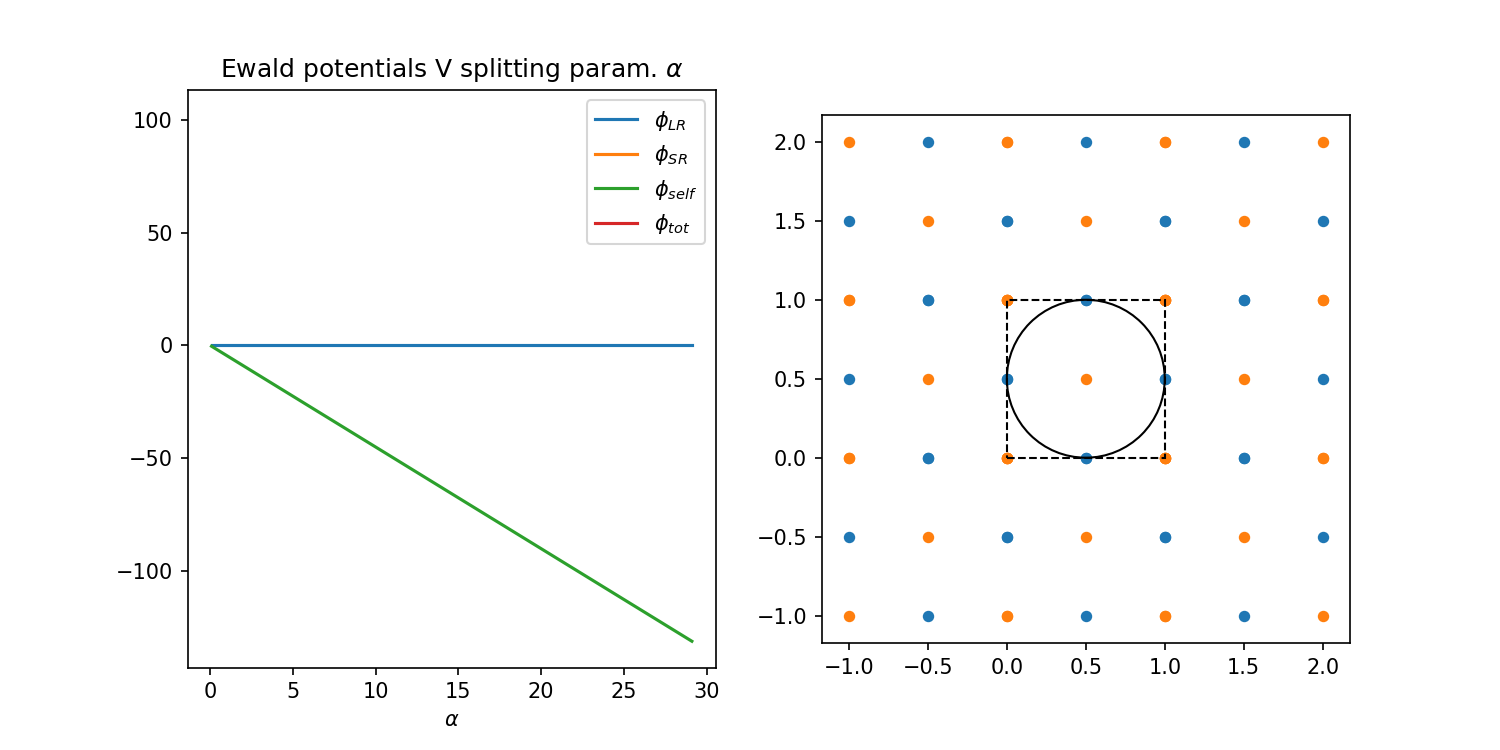

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='r', max=10.0, min=0.5, step…

In [5]:
charges = np.asarray([-1, -1., -1, -1, 1, 1, 1, 1])
coord = np.asarray([[0,0,0], [1/2,1/2,0], [1/2,0,1/2], [0,1/2,1/2],
                           [1/2,1/2,1/2], [1/2,0,0], [0,1/2,0],[0,0,1/2]])
E = Ewald(charges, (0,1), 0.1, 0.5, 1, 1)

fig, ax = plt.subplots(1,2,figsize=(10,5))
a_array, pot_lr, pot_sr, pot_self, pot_total =nacl_ewald(10, 10, 10, 30,1)
plt1,=ax[0].plot(a_array, pot_lr, label="$\phi_{LR}$")
plt2,=ax[0].plot(a_array, pot_sr, label="$\phi_{SR}$")
plt3,=ax[0].plot(a_array, -pot_self, label="$\phi_{self}$")
plt4,=ax[0].plot(a_array, pot_total, label="$\phi_{tot}$")

circle = plt.Circle([0.5,0.5], radius=0.5, fill=False)
box = patches.Rectangle([0,0],1,1, fill=False,linestyle='--')

def update(r=2., n=1, k=1):
    a_array, pot_lr, pot_sr, pot_self, pot_total=nacl_ewald(r, n, k, 30, 1, E)
    plt1.set_ydata(pot_lr)
    plt2.set_ydata(pot_sr)
    plt4.set_ydata(pot_total)
    fig.canvas.draw()
    
    ax[1].clear()
    circle.radius = r
    ax[1].add_patch(circle)
    ax[1].add_patch(box)
    n_array = np.mgrid[-n:n+1,-n:n+1].reshape(2,-1).T
    na_coord = np.asarray([[0,1/2],[1/2,0],[1,1/2],[1/2,1]])
    na_coord = (n_array[:,None,None] + na_coord).reshape(-1,2)
    cl_coord = np.asarray([[0,0],[0,1],[1,0],[1,1],[1/2,1/2]])
    cl_coord = (n_array[:,None,None] + cl_coord).reshape(-1,2)
    ax[1].scatter(na_coord[:,0],na_coord[:,1],s=20*min(1/n,1/r))
    ax[1].scatter(cl_coord[:,0],cl_coord[:,1],s=20*min(1/n,1/r))
    fig.canvas.draw()

ax[0].set_xlabel(r'$\alpha$')
ax[0].set_title(r'Ewald potentials V splitting param. $\alpha$')
ax[0].legend()
ax[1].set_aspect('equal')
w=interact(update,
        r=widgets.FloatSlider(min=0.5,max=10,step=0.25,value=0.5,continuous_update=False),
        k=widgets.IntSlider(min=1,max=10,step=1,value=1,continuous_update=False),
        n=widgets.IntSlider(min=1,max=10,step=1,value=1,continuous_update=False));

<IPython.core.display.Javascript object>


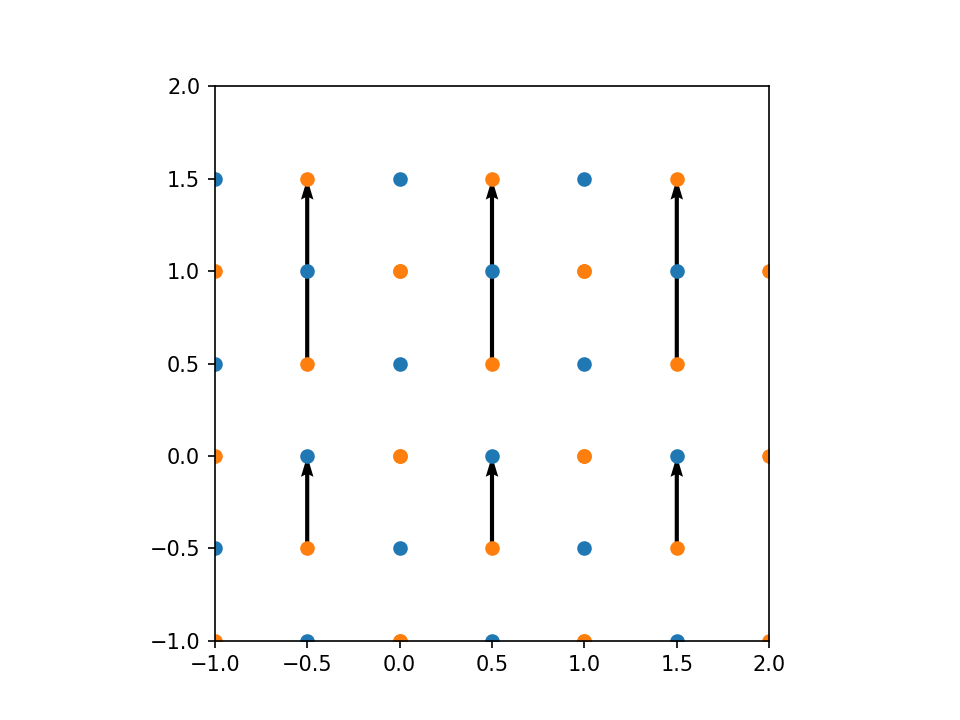

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='r', max=10.0, min=1.0, step…

In [6]:
E.params = 1, 2, 1,10
charges = np.asarray([-1, -1., -1, -1, 1, 1, 1, 1])
coord = np.asarray([[0,0,0], [1/2,1/2,0], [1/2,0,1/2], [0,1/2,1/2],
                           [1/2,1/2,1/2], [1/2,0,0], [0,1/2,0],[0,0,1/2]])


def update(r=0.5, k=1, n=1, alpha=0.1):
    ax.clear()
    E.params = alpha, r, n, k
    force = E.force(coord)
    na_force = np.asarray([force[5],force[6]])
    cl_force = np.asarray([force[0],force[1],force[0]])
    ax.set_xlim((-1,2))
    ax.set_ylim((-1,2))
    n_array = np.mgrid[-n:n+1,-n:n+1].reshape(2,-1).T
    na_coord = np.asarray([[1/2, 0],[0,1/2]])
    cl_coord = np.asarray([[0, 0],[1/2, 1/2],[1,0]])
    na_coord = (n_array[:,None,None] + na_coord).reshape(-1,2)
    cl_coord = (n_array[:,None,None] + cl_coord).reshape(-1,2)
    na_force = (np.zeros_like(n_array)[:,None,None] + na_force[:,:2]).reshape(-1,2)
    cl_force = (np.zeros_like(n_array)[:,None,None] + cl_force[:,:2]).reshape(-1,2)
    ax.quiver(na_coord[:,0],na_coord[:,1],na_force[:,0],na_force[:,1],angles='xy',scale_units="xy")
    ax.quiver(cl_coord[:,0],cl_coord[:,1],cl_force[:,0],cl_force[:,1],angles='xy',scale_units="xy")
    ax.scatter(na_coord[:,0],na_coord[:,1])
    ax.scatter(cl_coord[:,0],cl_coord[:,1])
    fig.canvas.draw()


fig, ax = plt.subplots()
plt.xlim((-1.5,2))
plt.ylim((-1.5,2))
ax.set_aspect("equal")

w=interact(update,
        r=widgets.FloatSlider(min=1,max=10,step=0.25,value=0.5,continuous_update=False),
        k=widgets.IntSlider(min=1,max=10,step=1,value=1,continuous_update=False),
        n=widgets.IntSlider(min=1,max=10,step=1,value=1,continuous_update=False),
        alpha=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=0.1, continuous_update=False));